In [116]:
# from google.colab import files

# # Upload zip file
# uploaded = files.upload()

In [117]:
# import zipfile
# import io

# # Get the first (and only) key in the dictionary
# zip_file_name = list(uploaded.keys())[0]

# with zipfile.ZipFile(io.BytesIO(uploaded[zip_file_name]), 'r') as zip_ref:
#     zip_ref.extractall('/content/')

In [118]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import re
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [119]:
# Updated TPU detection and initialization
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Device:', tpu.master())
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)  # Updated to non-experimental TPUStrategy
except ValueError:
  strategy = tf.distribute.get_strategy() # for CPU and single GPU
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.99.132.250:8470


Number of replicas: 8


In [120]:
train_data = pd.read_csv('/content/171_project/data/training.csv')

In [121]:
# For missing training data
print(f'Train sample: {len(train_data)}')
print('Percentage of missing values:')
train_data.isna().mean().round(4) * 100

Train sample: 7049
Percentage of missing values:


left_eye_center_x             0.14
left_eye_center_y             0.14
right_eye_center_x            0.18
right_eye_center_y            0.18
left_eye_inner_corner_x      67.78
left_eye_inner_corner_y      67.78
left_eye_outer_corner_x      67.84
left_eye_outer_corner_y      67.84
right_eye_inner_corner_x     67.83
right_eye_inner_corner_y     67.83
right_eye_outer_corner_x     67.83
right_eye_outer_corner_y     67.83
left_eyebrow_inner_end_x     67.80
left_eyebrow_inner_end_y     67.80
left_eyebrow_outer_end_x     68.44
left_eyebrow_outer_end_y     68.44
right_eyebrow_inner_end_x    67.80
right_eyebrow_inner_end_y    67.80
right_eyebrow_outer_end_x    68.28
right_eyebrow_outer_end_y    68.28
nose_tip_x                    0.00
nose_tip_y                    0.00
mouth_left_corner_x          67.81
mouth_left_corner_y          67.81
mouth_right_corner_x         67.80
mouth_right_corner_y         67.80
mouth_center_top_lip_x       67.73
mouth_center_top_lip_y       67.73
mouth_center_bottom_

In [122]:
num_rows = len(train_data)
print(f"Number of rows: {num_rows}")

Number of rows: 7049


In [123]:
for column in train_data.columns:
    train_data[column].fillna(train_data[column].median(), inplace=True)

In [124]:
num_rows = len(train_data)
print(f"Number of rows: {num_rows}")

Number of rows: 7049


In [125]:
# For missing training data
print(f'Train sample: {len(train_data)}')
print('Percentage of missing values:')
train_data.isna().mean().round(4) * 100

Train sample: 7049
Percentage of missing values:


left_eye_center_x            0.0
left_eye_center_y            0.0
right_eye_center_x           0.0
right_eye_center_y           0.0
left_eye_inner_corner_x      0.0
left_eye_inner_corner_y      0.0
left_eye_outer_corner_x      0.0
left_eye_outer_corner_y      0.0
right_eye_inner_corner_x     0.0
right_eye_inner_corner_y     0.0
right_eye_outer_corner_x     0.0
right_eye_outer_corner_y     0.0
left_eyebrow_inner_end_x     0.0
left_eyebrow_inner_end_y     0.0
left_eyebrow_outer_end_x     0.0
left_eyebrow_outer_end_y     0.0
right_eyebrow_inner_end_x    0.0
right_eyebrow_inner_end_y    0.0
right_eyebrow_outer_end_x    0.0
right_eyebrow_outer_end_y    0.0
nose_tip_x                   0.0
nose_tip_y                   0.0
mouth_left_corner_x          0.0
mouth_left_corner_y          0.0
mouth_right_corner_x         0.0
mouth_right_corner_y         0.0
mouth_center_top_lip_x       0.0
mouth_center_top_lip_y       0.0
mouth_center_bottom_lip_x    0.0
mouth_center_bottom_lip_y    0.0
dtype: flo

In [126]:
def sort_pattern(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def load_images(path):
    images = []
    file_list = os.listdir(path)
    sorted_file_list = sorted(file_list, key=sort_pattern)

    for filename in sorted_file_list:
        if filename.endswith(".jpg"):  # Assuming images are in JPG format
            img_path = os.path.join(path, filename)
            img = Image.open(img_path).convert('L')
            img = img.resize((227, 227))  # Resize for AlexNet
            images.append(np.array(img))  # Convert PIL Image to NumPy array
            img.close()

    return images

def show_keypoints(images, keypoints, n_rows=3, n_cols=7, original_size=96, new_size=227):
    scaling_factor = new_size / original_size
    scaled_keypoints = keypoints * scaling_factor

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows), dpi=100)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flatten()):
        if i >= len(images):
            break  # If there are fewer images than subplots, exit the loop early

        img_array = images[i]
        if img_array.shape[0] != new_size or img_array.shape[1] != new_size:
            raise ValueError(f"Image size expected to be {new_size}x{new_size}, but was {img_array.shape[0]}x{img_array.shape[1]}")

        ax.imshow(img_array, cmap='gray')
        ax.axis('off')  # Hide the axis
        ax.set_title(f'Sample #{i}')

        # Keypoints are expected to be in (x, y) pairs
        for j in range(0, len(keypoints[i]), 2):
            x = scaled_keypoints[i][j]
            y = scaled_keypoints[i][j + 1]
            ax.plot(x, y, 'ro', markersize=2)

    plt.tight_layout()
    plt.show()

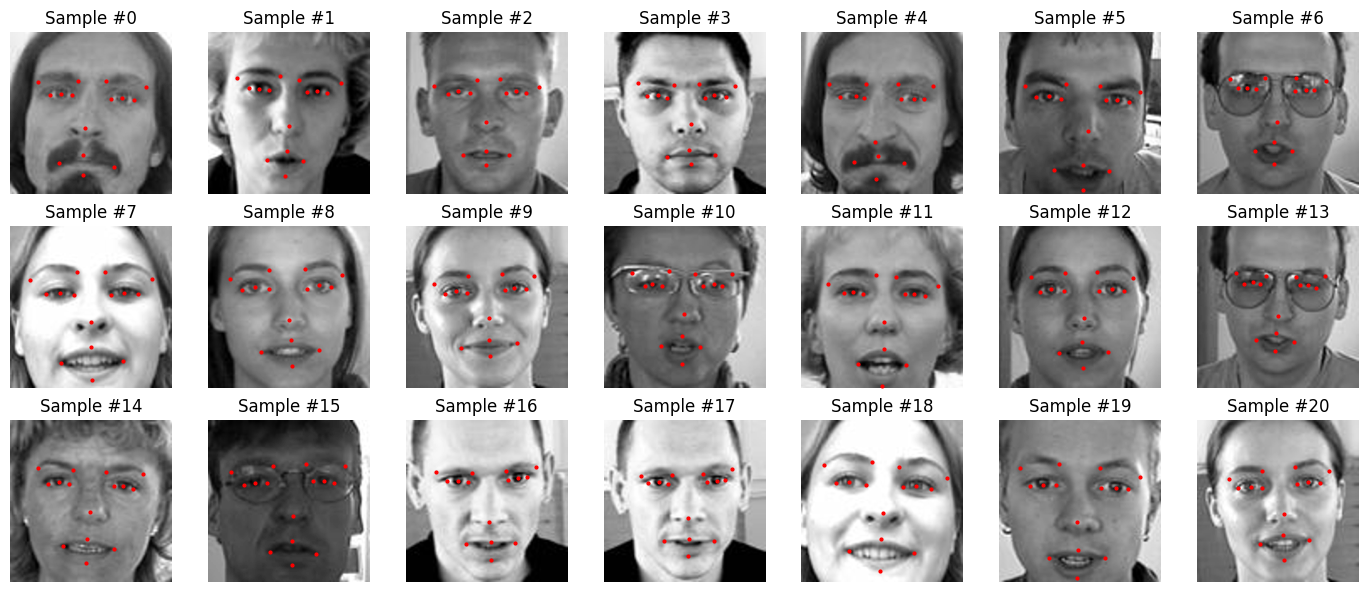

In [127]:
path = r"/content/171_project/data/images/train_images"

images = load_images(path)

# Filter images to only include those with indices that are in train_data.index after dropping rows.
images = [image for index, image in enumerate(images) if index in train_data.index]

show_keypoints(images[:21], train_data.values[:21])

x_train = np.array(images).reshape(-1, 227, 227, 1).astype('float64')
y_train = train_data.values.astype('float64')

In [128]:
# Assuming x_train and y_train are already defined as your full dataset
# Split the data into training and validation sets (80% train, 20% validation)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=21)

# Make sure the data is in the correct shape and type
x_train = x_train.reshape(-1, 227, 227, 1).astype('float64')
x_val = x_val.reshape(-1, 227, 227, 1).astype('float64')

In [129]:
with strategy.scope():
    def AlexNet(input_shape=(227, 227, 1), num_outputs=30):
        model = Sequential([
            # 1st Convolutional Layer
            Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='valid', activation='relu', input_shape=input_shape),
            BatchNormalization(),
            MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

            # 2nd Convolutional Layer
            Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

            # 3rd Convolutional Layer
            Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
            BatchNormalization(),

            # 4th Convolutional Layer
            Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
            BatchNormalization(),

            # 5th Convolutional Layer
            Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

            # Passing it to a Fully Connected layer
            Flatten(),

            # 1st Fully Connected Layer
            Dense(4096, activation='relu'),
            Dropout(0.5),
            BatchNormalization(),

            # 2nd Fully Connected Layer
            Dense(4096, activation='relu'),
            Dropout(0.5),
            BatchNormalization(),

            # Output Layer for Regression
            Dense(num_outputs)  # No activation function (linear)
        ])
        return model

    alexnet_model = AlexNet(input_shape=(227, 227, 1), num_outputs=30)
    alexnet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 55, 55, 96)        11712     
                                                                 
 batch_normalization_42 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_43 (Bat  (None, 27, 27, 256)      1024      
 chNormalization)                                                
                                                      

In [130]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1,
                               mode='min',
                               restore_best_weights=True)

reduce_LR = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=5,
                              verbose=1,
                              mode='min',
                              min_lr=1e-9)

# Compile model with a lower initial learning rate
alexnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['mae'])

In [131]:
# Adjust batch size and add TerminateOnNaN callback
batch_size = 24 * strategy.num_replicas_in_sync
terminate_on_nan = tf.keras.callbacks.TerminateOnNaN()

history = alexnet_model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_LR, terminate_on_nan]
)

Epoch 1/100
30/30 [==============================] - 42s 806ms/step - loss: 2627.3018 - mae: 47.7587 - val_loss: 2613.2896 - val_mae: 47.4771 - lr: 1.0000e-04
Epoch 2/100
30/30 [==============================] - 3s 96ms/step - loss: 2618.9712 - mae: 47.6889 - val_loss: 2615.4563 - val_mae: 47.5766 - lr: 1.0000e-04
Epoch 3/100
30/30 [==============================] - 4s 127ms/step - loss: 2601.3713 - mae: 47.5247 - val_loss: 2568.1011 - val_mae: 47.1175 - lr: 1.0000e-04
Epoch 4/100
30/30 [==============================] - 3s 118ms/step - loss: 2568.8057 - mae: 47.2033 - val_loss: 2544.4004 - val_mae: 46.8748 - lr: 1.0000e-04
Epoch 5/100
30/30 [==============================] - 3s 117ms/step - loss: 2518.1738 - mae: 46.6875 - val_loss: 2463.5088 - val_mae: 46.0830 - lr: 1.0000e-04
Epoch 6/100
30/30 [==============================] - 4s 121ms/step - loss: 2449.0244 - mae: 45.9645 - val_loss: 2371.8638 - val_mae: 45.1251 - lr: 1.0000e-04
Epoch 7/100
30/30 [==============================] -

In [132]:
# Save the trained model to a file
alexnet_model.save('alexnet_model.h5')
# Download the saved model file
files.download('alexnet_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

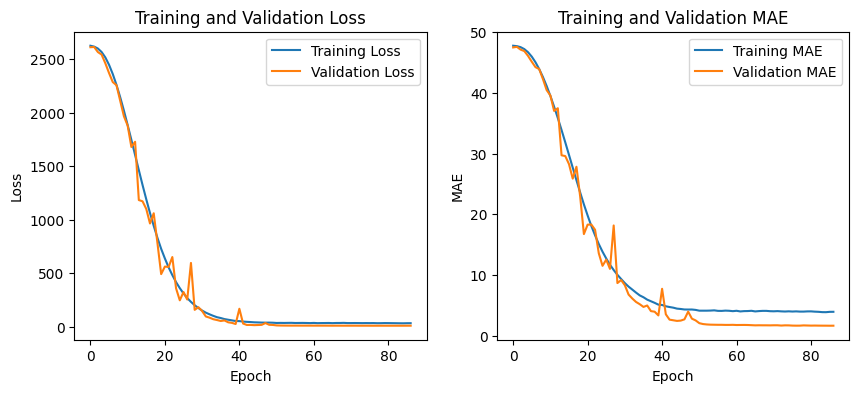

In [133]:
#### 1. Training Loss and Validation Loss

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#### 2. Training MAE and Validation MAE

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()
